# Company A - Data Description

In this notebook, below are what to be included:
* data inspection & description
* feature engineering
* correlation matrix


**key business metrics**

| Input      | Output |
| ----------- | ----------- |
| **Air consumption**|**Surface Area**|
| **Gas consumption**|**Compacite**|
| **Exhaust gas**|**D50**|
| **Speed**|D90|
| **Pressure**|B2O3|
| **Kiln Feed**|Na2O|
| **Dust Addition**| |
| Moisture Beltweigher| |
| Moisture CLC| |
| Additive B| |
| Additive A (C?)| |
| CLC CaO| |
| CLC Na2O| |

In [1]:
# key metrics
col = ["Air consumption","Gas consumption","Exhaust gas","Speed","Pressure","Kiln Feed","Dust Addition","Moisture Beltweigher","Moisture CLC","Additive B","Additive C","CLC CaO","CLC Na2O",
       "Surface Area","Compacite","d50",
       "d90","B₂O₃","Na₂O"]

## Import packages

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy
import seaborn as sn
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt
from astropy.visualization import hist
# Astropy histogram: https://astropy.readthedocs.io/en/latest/visualization/histogram.html#bayesian-models

## Load data

In [3]:
df = pd.read_excel('2018-Ofen 6-Lehigh data.xlsx')

In [4]:
df.shape

(3144, 51)

In [5]:
print("Column headings:",len(df.columns))
print(df.columns)

Column headings: 51
Index(['Date', 'Product Goal', 'Product Made', 'Air consumption',
       'Gas consumption', 'Exhaust gas', 'Speed', 'Pressure', 'Kiln Feed',
       'Dust Addition', 'Moisture Beltweigher', 'Moisture CLC', 'Additive B',
       'Additive C', 'CLC CaO', 'CLC Na2O', 'Efficiency', 'Power consumption',
       'Gaszähler Ofen 6', 'Pyrometer', 'Temperature Kiln head',
       'Inner Temperature of the Kiln', 'End Temperature of Kiln',
       'Input Temperature Baghouse filter', 'Exhaust Gas Temperature',
       'Dust Collection', 'CLC B2O3', 'CLC Fe2O3', 'CLC MgO', 'CLC SiO2',
       'CLC TiO2', 'pH', 'pH value CLC', 'CO2', 'CO', 'B2O3 Dust', 'Na2O Dust',
       'Surface Area', 'Compacite', 'd50', 'd50-2', 'd90', '+ 0.063 mm',
       'Loose Bulk Density', 'B₂O₃', 'CaO', 'Fe₂O₃', 'MgO', 'SiO₂', 'Na₂O',
       'TiO₂'],
      dtype='object')


## Data inspection

In [6]:
print(scipy.stats.describe(df[df['CLC CaO'].notnull()]['CLC CaO']))

DescribeResult(nobs=878, minmax=(0.002, 0.028), mean=0.014053530751708431, variance=3.1706367223112546e-05, skewness=-0.699957542803772, kurtosis=-0.5069401323062324)


## Data distribution plot

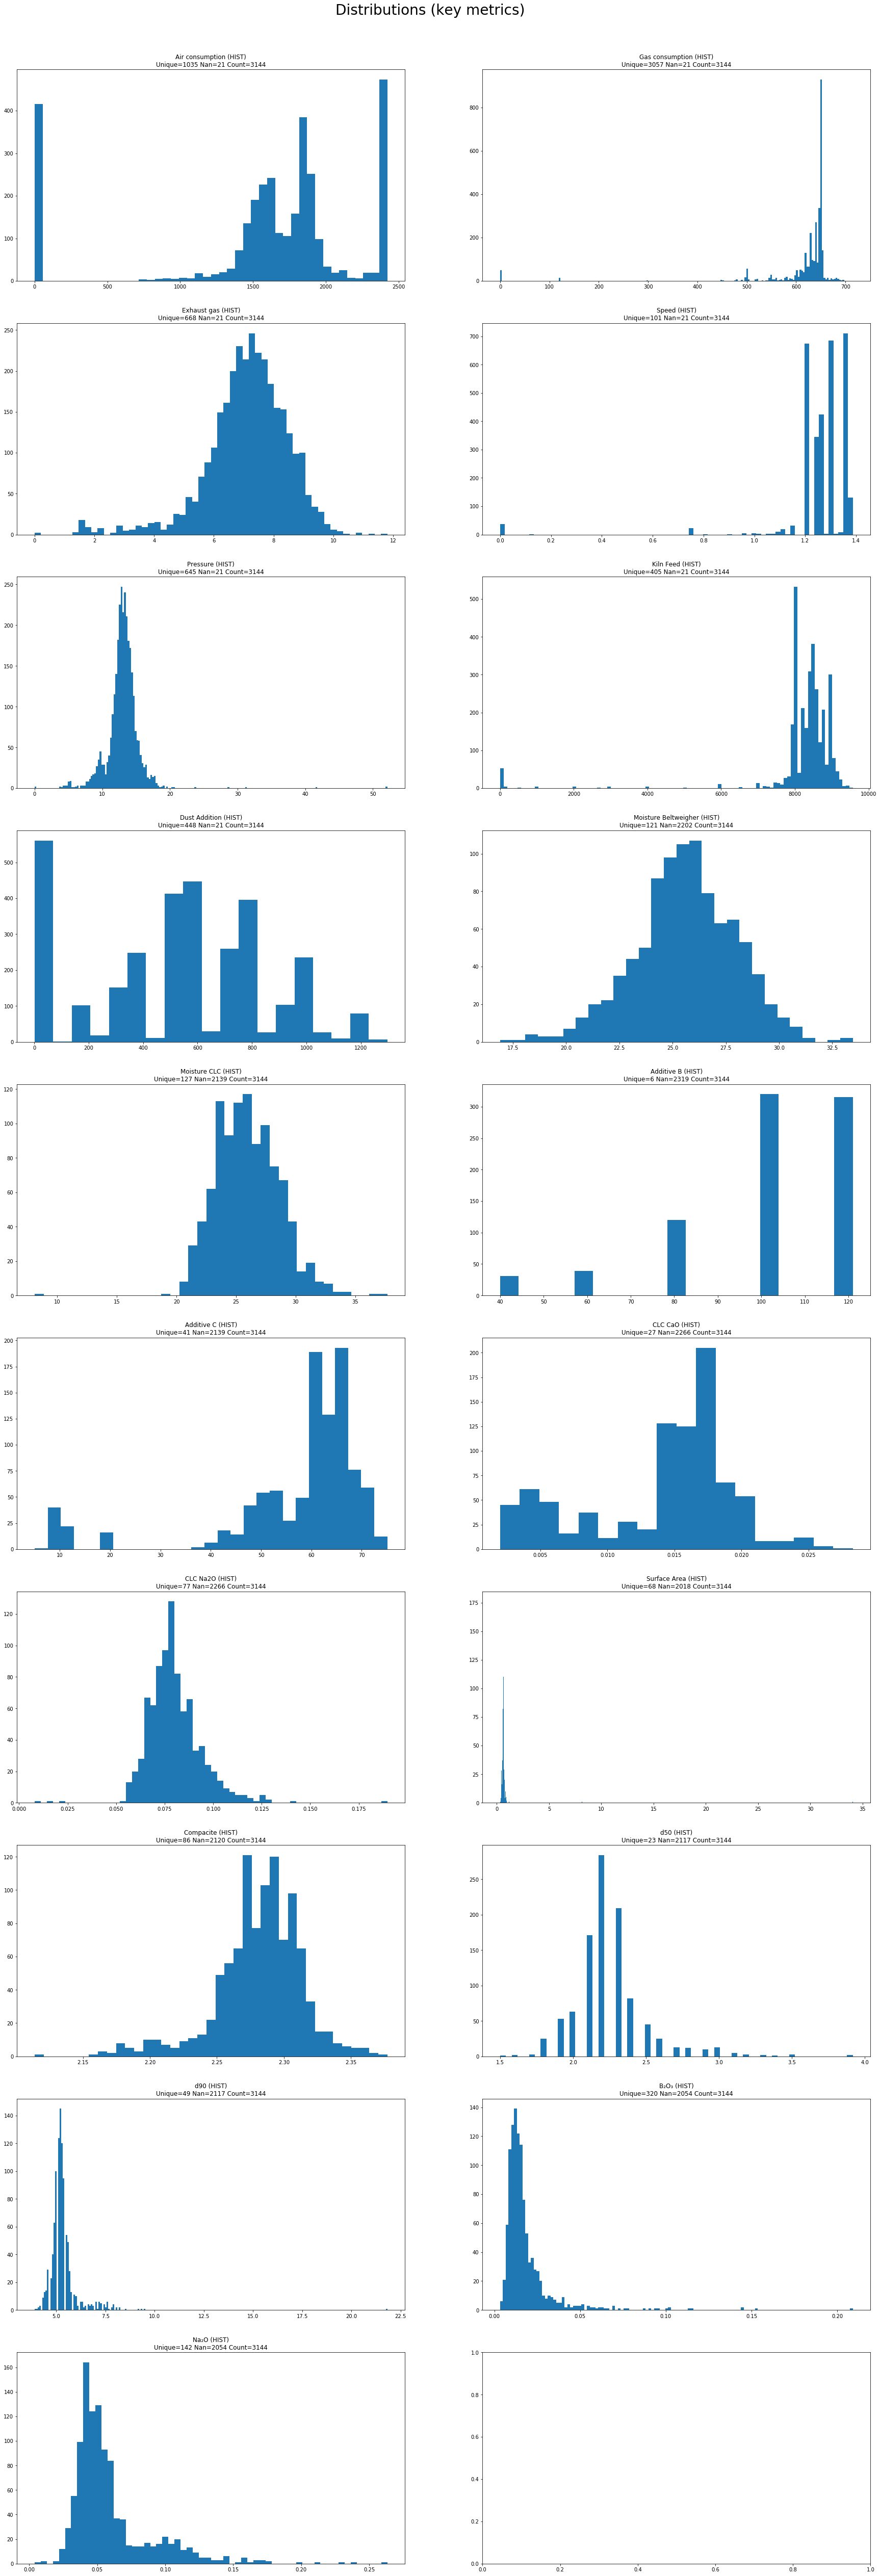

In [7]:
fig, axes = plt.subplots(nrows=int(np.ceil(len(col)/2)), ncols=2, figsize=((30,90)))
fig.suptitle('Distributions (key metrics)', y =0.9, fontsize=28)

axs = axes.flatten()

for i,w in enumerate(col):
    print(i,":",w,"*"*i, end="\r")
    n_uniq = len(df[w].unique())
    n_nan = df[w].isna().sum()
    n_all = len(df[w])
    try: # histogram
        hist(df[df[w].notnull()][w], ax=axs[i], bins='freedman')
        typ = "HIST"
    except: # categorical
        df[w].value_counts().sort_index().plot(kind="bar", ax=axs[i])
        typ = "CAT"
    finally: 
        axs[i].set_title("{} ({})\nUnique={} Nan={} Count={}".format(w,typ,n_uniq,n_nan,n_all))
        #axs[i].text(0.5, 0.5, scipy.stats.describe(df[df[w].notnull()][w]).mean, horizontalalignment='center', verticalalignment='center')

## Feature Engineering

#### (a) Remove invalid data points & convert cat to num
This includes rows with "Product Made" column = "Kiln Maintenance", "Maintenance on the Kiln", or blank rows.

In [12]:
data = df.loc[df['Product Made'].isin(['A','B','C','D','F','G','H','I'])]

In [13]:
data.shape

(3068, 51)

In [16]:
product_type = ['A','B','C','D','F','G','H','I']
# change string cat to num
data['Product Goal'] = data['Product Goal'].astype("category").cat.codes
data['Product Made'] = data['Product Made'].astype("category").cat.codes

/Users/joshagar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/joshagar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [17]:
data['Product Goal'].unique()

array([1, 0, 4, 3, 2])

In [18]:
data['Product Made'].unique()

array([1, 2, 3, 0, 5, 6, 7, 4])

In [19]:
data.shape

(3068, 51)

## Product Match

In [20]:
result = confusion_matrix(data['Product Goal'], data['Product Made'])

Text(0.5, 1, 'Confusion Matrix')

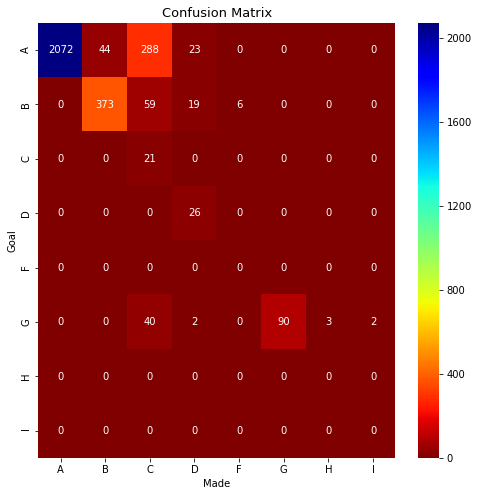

In [232]:
df_cm = pd.DataFrame(result, index = product_type, columns = product_type)
plt.figure(figsize = (8,8))
ax = sn.heatmap(df_cm, annot=True, fmt='d', cmap='jet_r')
ax.set(xlabel='Made', ylabel='Goal')
ax.set_title("Confusion Matrix", fontsize=13)
#ax.invert_yaxis()

## Correlation matrix
(no need to normalize here, corr is auto-normalized)

In [246]:
# Selection and Normalize
from sklearn import preprocessing
# removing null values in input
df_filtered = data[col][data["Speed"].notnull()]
# removing null values in key output
df_filtered = data_to_save[data_to_save["Surface Area"].notnull()]

'''
# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()
# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(df_filtered)
# Run the normalizer on the dataframe & fill NaN
df_normalized = pd.DataFrame(x_scaled).fillna(0)
'''

'\n# Create a minimum and maximum processor object\nmin_max_scaler = preprocessing.MinMaxScaler()\n# Create an object to transform the data to fit minmax processor\nx_scaled = min_max_scaler.fit_transform(df_filtered)\n# Run the normalizer on the dataframe & fill NaN\ndf_normalized = pd.DataFrame(x_scaled).fillna(0)\n'

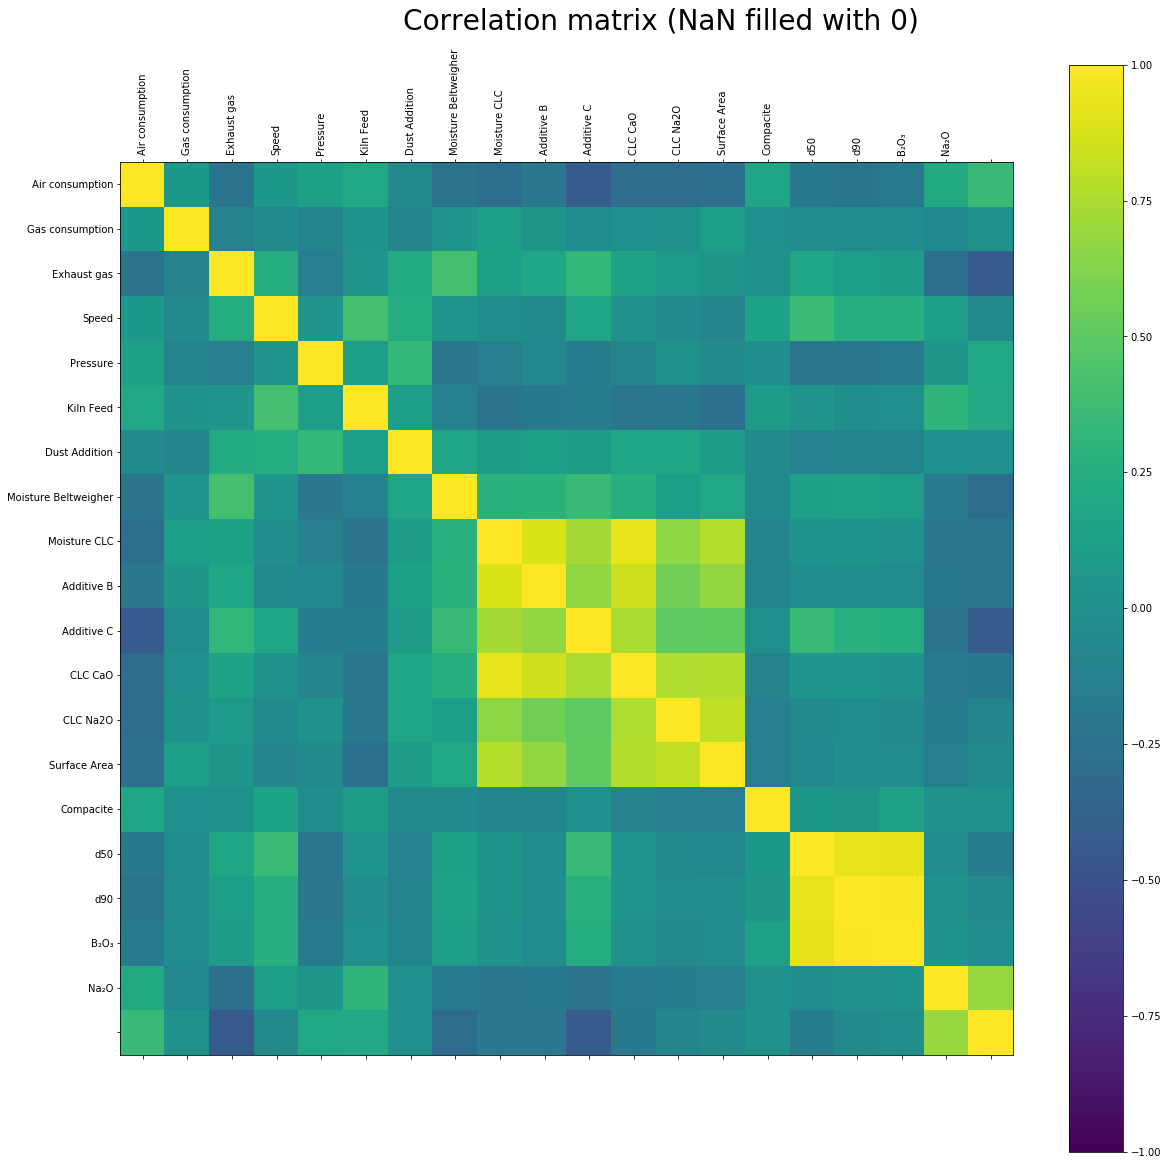

In [248]:
# plot correlation matrix
corr = df_filtered.corr()
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='viridis', vmin=-1, vmax=1, )
fig.colorbar(cax)
ticks = np.arange(0,len(df_filtered.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(col)
ax.set_yticklabels(col)
fig.suptitle("Correlation matrix (NaN filled with 0)", y=0.92, fontsize=28)
plt.show()

## Save data to pickle

In [21]:
# the data still have NaN values
data[col].isna().sum()

Air consumption            2
Gas consumption            2
Exhaust gas                2
Speed                      2
Pressure                   2
Kiln Feed                  2
Dust Addition              2
Moisture Beltweigher    2134
Moisture CLC            2071
Additive B              2251
Additive C              2071
CLC CaO                 2198
CLC Na2O                2198
Surface Area            1951
Compacite               2053
d50                     2050
d90                     2050
B₂O₃                    1987
Na₂O                    1987
dtype: int64

### You made a mistake here. You removed way too much of the data here

In [25]:
data
data.to_pickle("full_data.pkl")

* We cannot just throw out all the incomplete examples. We need to work with what we have. That means guessing on some. 

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3068 entries, 0 to 3143
Data columns (total 51 columns):
Date                                 3068 non-null datetime64[ns]
Product Goal                         3068 non-null int8
Product Made                         3068 non-null int8
Air consumption                      3066 non-null float64
Gas consumption                      3066 non-null float64
Exhaust gas                          3066 non-null float64
Speed                                3066 non-null float64
Pressure                             3066 non-null float64
Kiln Feed                            3066 non-null float64
Dust Addition                        3066 non-null float64
Moisture Beltweigher                 934 non-null float64
Moisture CLC                         997 non-null float64
Additive B                           817 non-null float64
Additive C                           997 non-null float64
CLC CaO                              870 non-null float64
CLC Na2O    

/Users/joshagar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


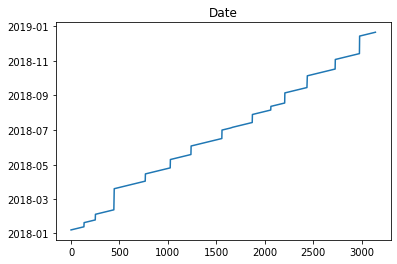

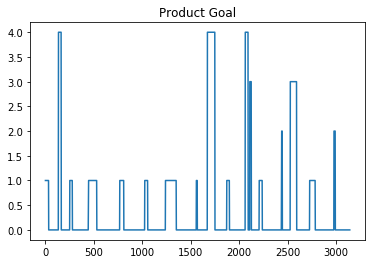

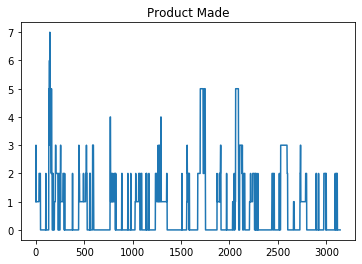

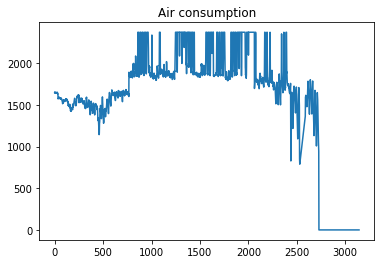

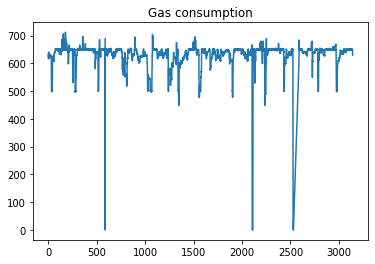

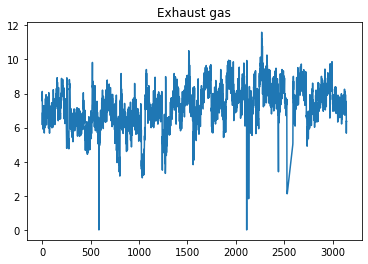

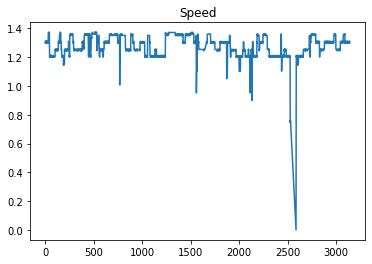

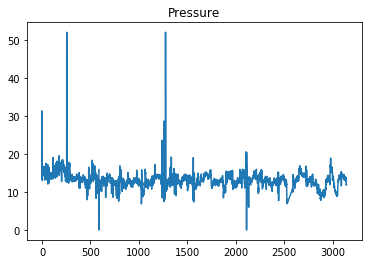

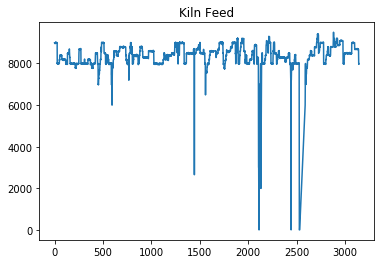

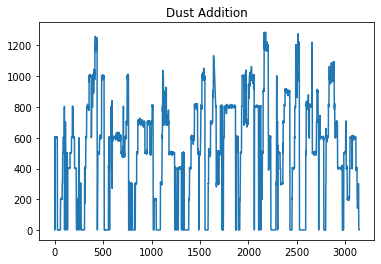

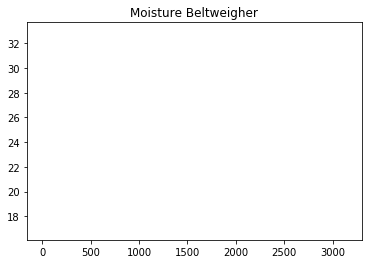

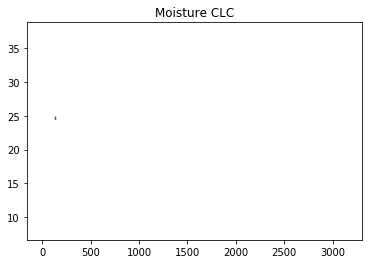

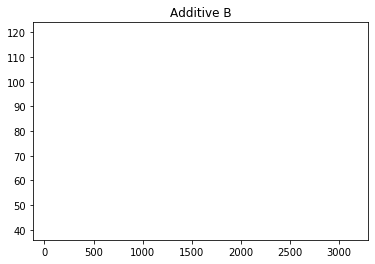

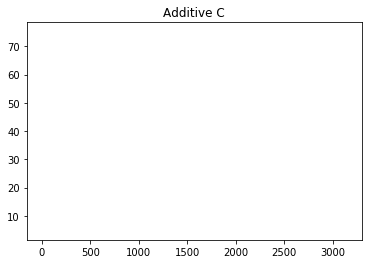

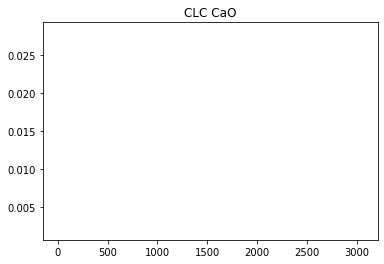

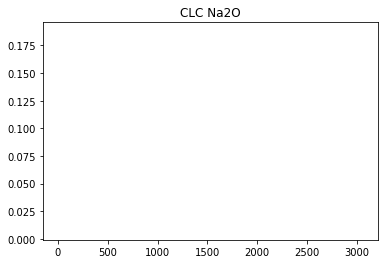

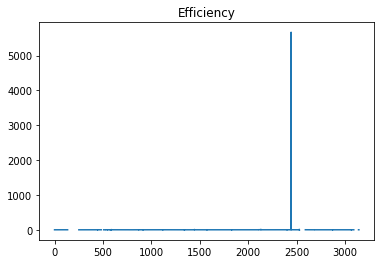

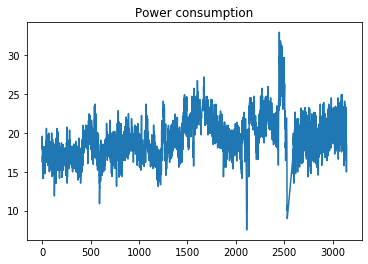

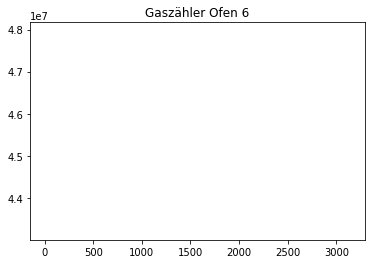

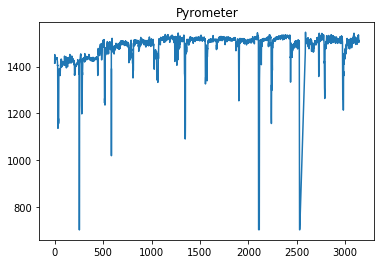

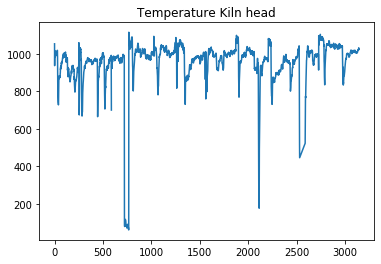

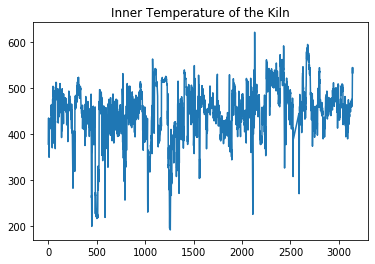

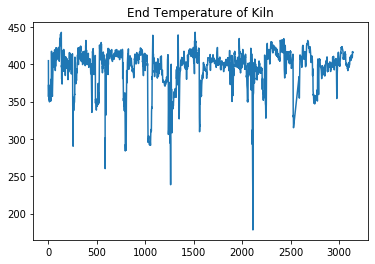

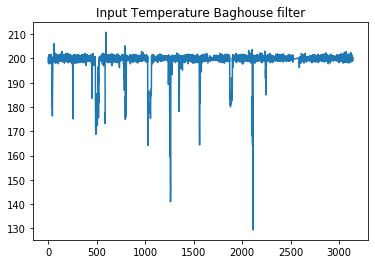

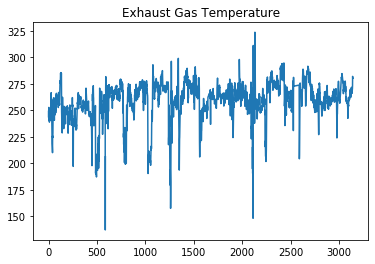

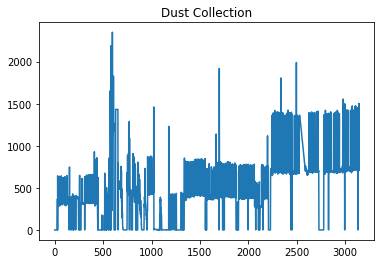

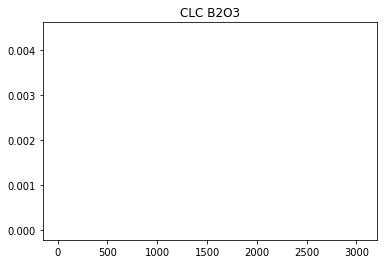

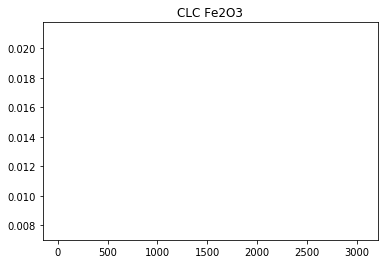

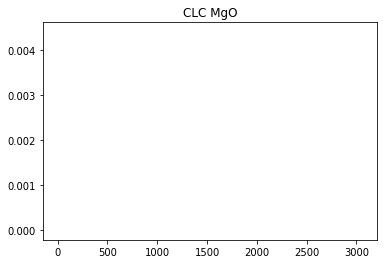

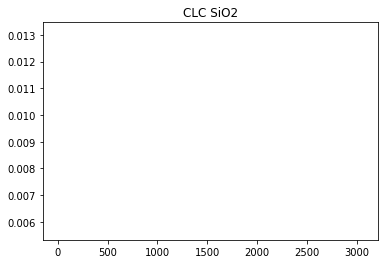

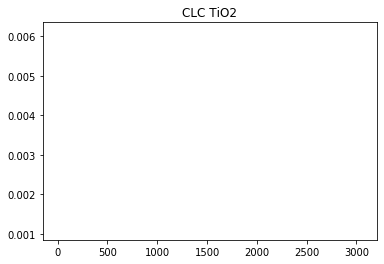

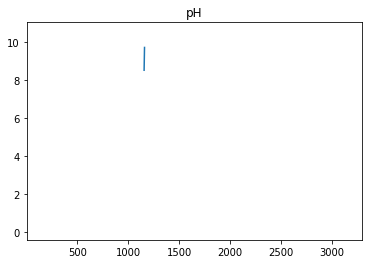

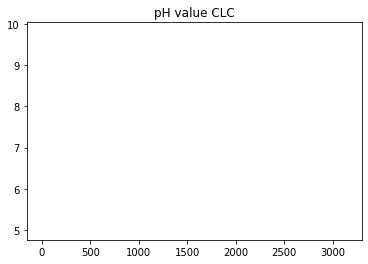

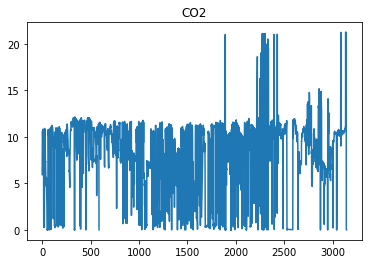

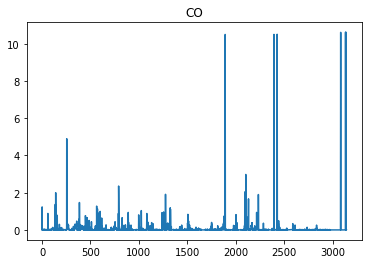

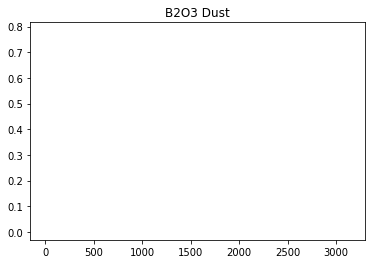

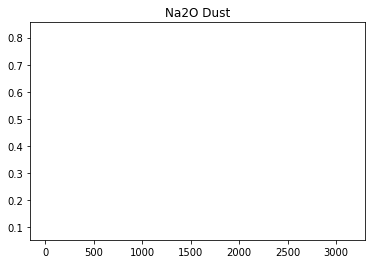

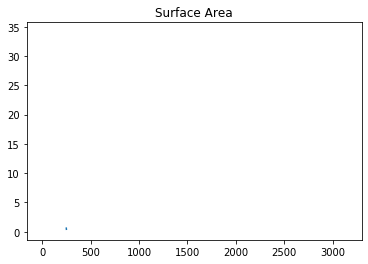

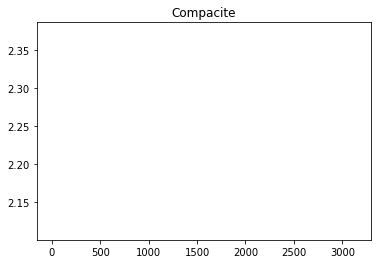

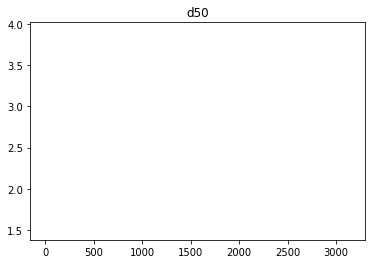

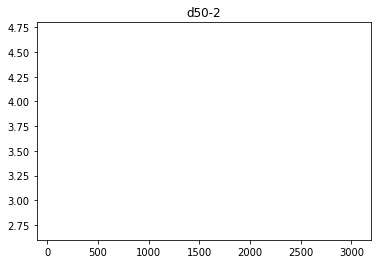

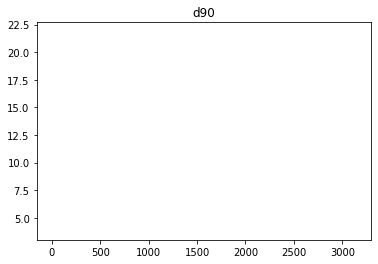

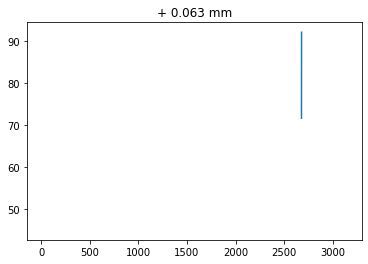

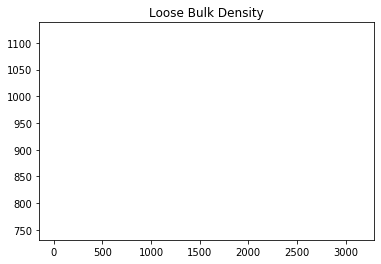

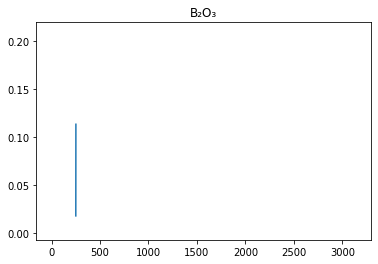

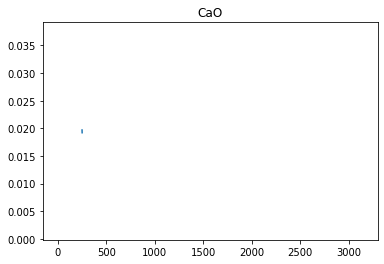

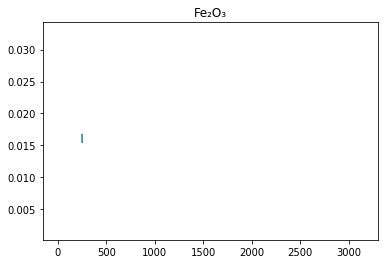

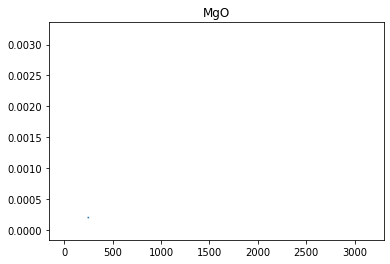

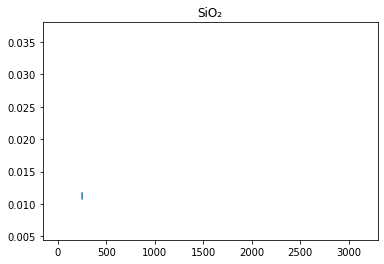

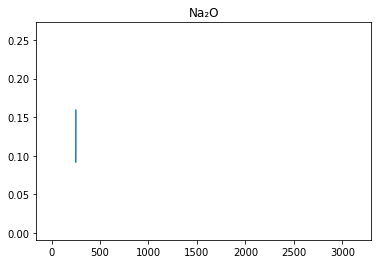

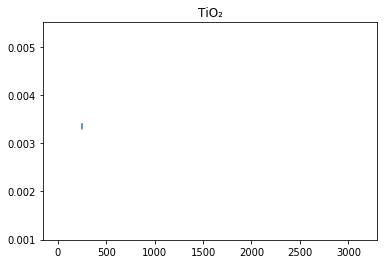

In [43]:
data.isnull=0

for i, name in enumerate(data.columns):
    plt.figure()
    plt.plot(data[name])
    plt.title(name)

In [253]:
# removing null values in input
data_to_save = data[['Product Made']+col][data["Speed"].notnull()]
print(data_to_save.shape)
# removing null values in key output
data_to_save = data_to_save[data_to_save["Surface Area"].notnull()]
print(data_to_save.shape)
# fill NaN with zero *with assumption that NaN means total absence upon product inspection
data_to_save = data_to_save.fillna(0)
print(data_to_save.shape)
data_to_save

(3066, 20)
(1116, 20)
(1116, 20)


,Product Made,Air consumption,Gas consumption,Exhaust gas,Speed,Pressure,Kiln Feed,Dust Addition,Moisture Beltweigher,Moisture CLC,Additive B,Additive C,CLC CaO,CLC Na2O,Surface Area,Compacite,d50,d90,B₂O₃,Na₂O
1,2,1652.198975,621.300781,8.125000,1.297454,31.307871,8993.055664,1.620370,21.8,22.9,0.0,60.0,0.018,0.094,0.43,2.332,2.9,6.8,0.0511,0.134
4,1,1651.041626,641.031738,6.883681,1.310185,13.541667,8955.439453,601.967590,22.0,23.4,0.0,60.0,0.019,0.085,0.47,2.330,3.0,6.9,0.0313,0.121
7,1,1639.467651,631.351685,5.920139,1.310185,14.250578,8972.800781,600.347229,22.2,23.0,0.0,60.0,0.019,0.087,0.48,2.308,3.0,7.0,0.0335,0.115
10,1,1645.833374,628.610840,6.059028,1.310185,15.364583,9019.096680,601.967590,22.3,25.6,0.0,60.0,0.018,0.087,0.49,2.319,2.8,6.6,0.0222,0.109
13,1,1640.046265,629.337646,6.579861,1.297454,15.364583,8964.120117,601.967590,23.4,24.9,0.0,60.0,0.019,0.083,0.48,0.000,0.0,0.0,0.0247,0.109
16,1,1639.467651,629.951477,6.866320,1.310185,16.710070,9013.310547,605.208313,24.4,24.1,0.0,60.0,0.019,0.082,0.45,0.000,0.0,0.0,0.0191,0.103
19,1,1646.411987,629.395996,6.875000,1.297454,15.321180,8995.949219,603.587952,23.9,22.6,0.0,60.0,0.019,0.080,0.47,0.000,0.0,0.0,0.0000,0.000
22,1,1649.305542,630.262390,5.685764,1.297454,15.190972,9004.629883,601.967590,23.2,29.7,0.0,60.0,0.019,0.081,0.47,2.330,2.9,6.8,0.0275,0.121
25,1,1641.203735,629.797058,6.579861,1.310185,15.321180,8993.055664,600.347229,26.1,22.8,0.0,64.0,0.019,0.080,0.47,0.000,0.0,0.0,0.0381,0.133
28,1,1644.097168,623.721497,6.145833,1.297454,14.728010,7991.897949,2.430556,24.3,25.9,0.0,64.0,0.019,0.081,0.49,0.000,0.0,0.0,0.0132,0.112


In [192]:
data_to_save.to_pickle("mod_data.pkl")